# Akita Tutorial: CTCF Insertions into Background Sequence
 
This tutorial demonstrates usage of [akita_utils](https://github.com/Fudenberg-Research-Group/akita_utils) to perform CTCF insertions into a neutral background sequence, which we also term 'virtual insertion screening'.
    
This involves:

1. Loading the trained model
2. Opening the relevant genome
3. Loading background sequences
4. Reading a table with the genomic coordinates of CTCF sites
5. Setting up a sequence generator to insert CTCF sites
6. Making predictions before and after CTCF disruptions
7. Visualizing the predicted changes in contact maps


In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import subprocess
import json
import pandas as pd
import pysam
import numpy as np
import tensorflow as tf
from basenji import seqnn, stream
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("../figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_1hot
from akita_utils.numpy_utils import ut_dense
from akita_utils.seq_gens import symmertic_insertion_seqs_gen

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# arguments 
 
stats = "SCD" 
batch_size = 8 # Estimated memory for one sequence: 160MB
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = "./mm10/example_background_sequence_model_1.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

# table with CTCF coordinates
CTCF_table = "./tables/insertion_examples.tsv"

params_file = "./model_files/params.json"
model_file = "./model_files/model1_best.h5"

### Loading the model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Opening the mm10 genome

In [5]:
if not os.path.isfile('./mm10/mm10.ml.fa'):
    print('downloading mm10.ml.fa')
    subprocess.call('curl -o ./mm10/mm10.ml.fa.gz ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M22/GRCm38.p6.genome.fa.gz', shell=True)
    subprocess.call('gunzip ./mm10/mm10.ml.fa.gz', shell=True)

In [6]:
# open genome FASTA
genome_open = pysam.Fastafile('./mm10/mm10.ml.fa')

### Providing input sequences and insertion parameters


The input sequences are generated from a table of CTCF site positions along with insertion parameters (e.g., the number of sites and their orientation), read from a TSV. This table is used by the sequence generator to create the sequences that are fed into AkitaV2. 
In this tutorial, CTCF sites are inserted in one copy, in the middle of the background sequence in the rightward (>) orientation.

For this tutorial, we have selected a set of CTCF sites representing a range of insertion effects: strong, medium, and weak.

#### Reading the table with insertion parameters

In [7]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")

### Predictions for (reference) background sequences

Neutral background sequences were shuffled to minimize their apparent genome folding, as predicted by Akita, and saved as a FASTA file.

In [8]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

In [9]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

1/1 [==============================] - 3s 3s/step


### Predictions using a sequence generator for insertions

In [10]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [11]:
num_experiments = len(seq_coords_df)

# picking target to display
target_index = 0  # data from Hsieh et al., 2020.


### Visualizing predicted insertions

Maps are displayed in order from CTCF sites with the strongest insertion effects to those with the weakest.   
Each row displays the predicted map before and after the insertion of a single CTCF site, along with the difference map.

2/2 [==============================] - 14s 3s/step


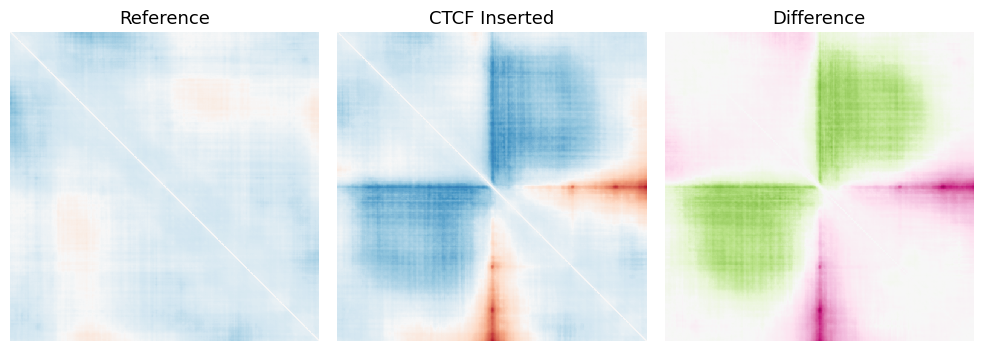

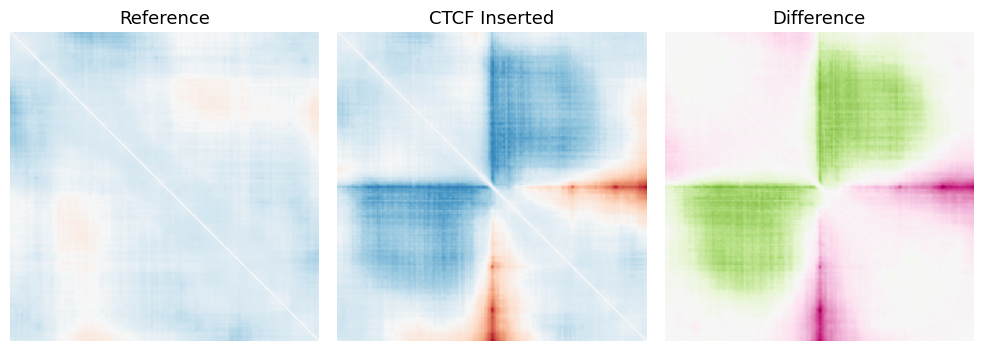

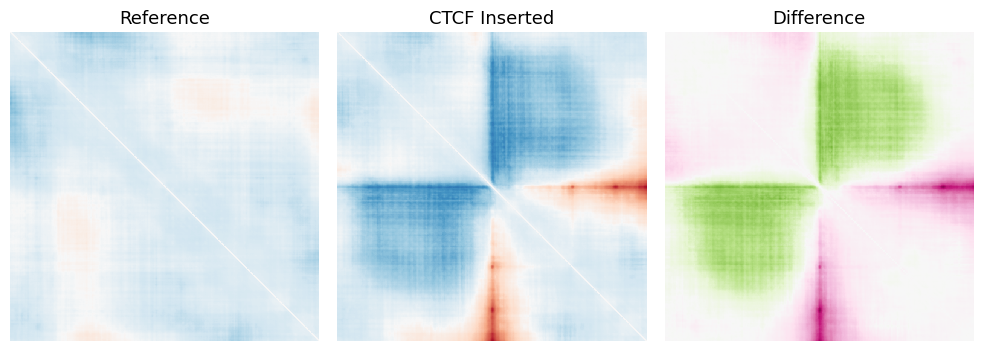

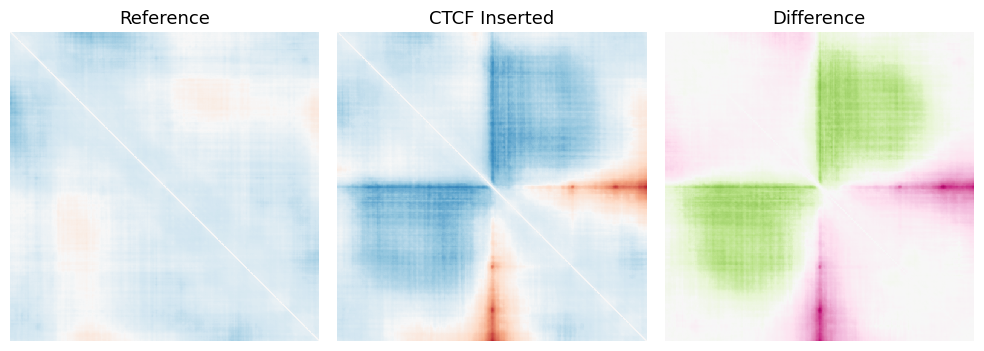

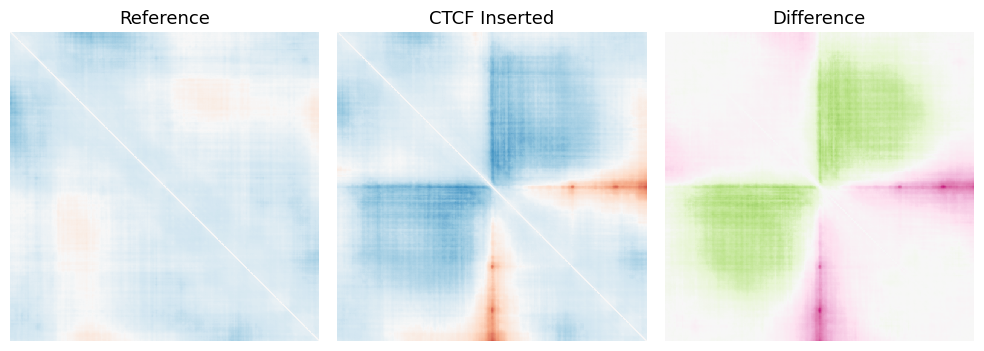

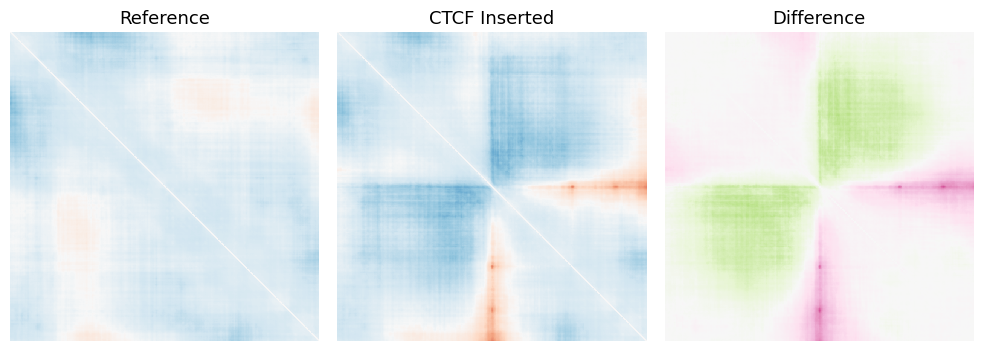

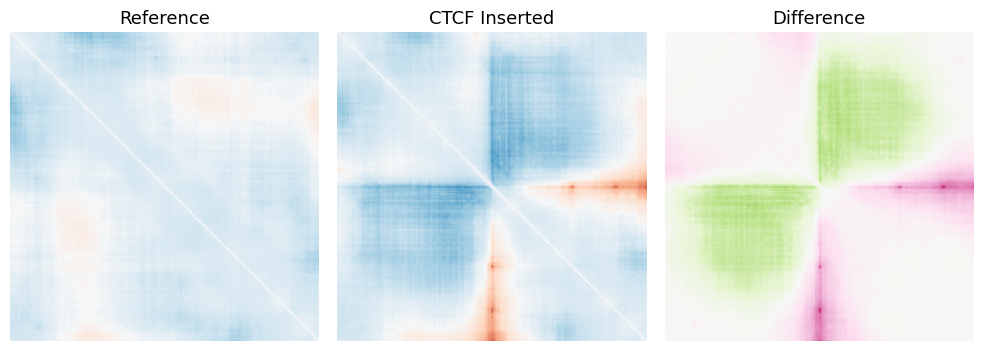

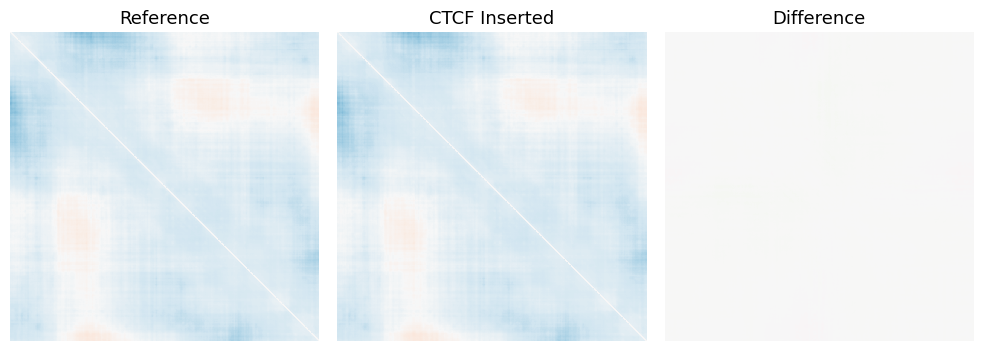

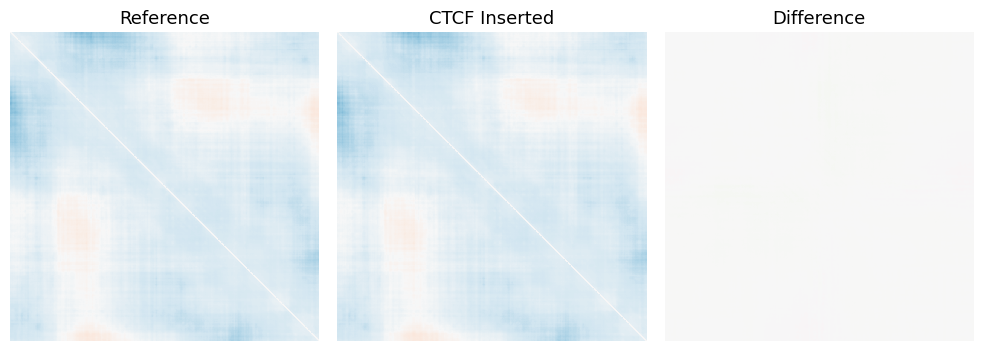

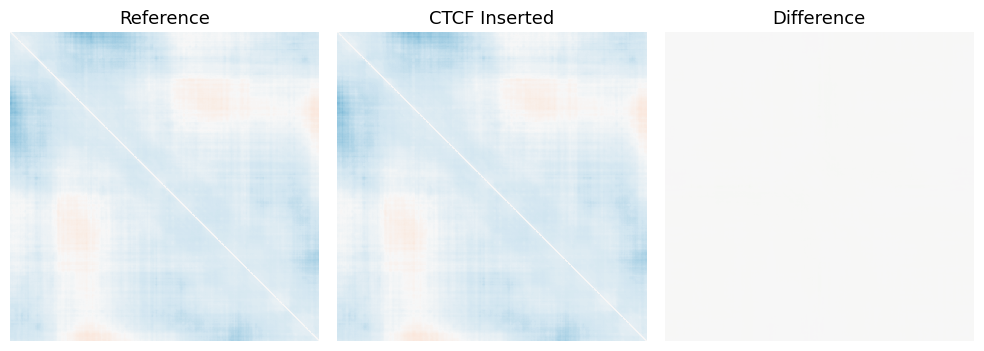

In [12]:
for exp_index in range(num_experiments):
    
    bg_index = seq_coords_df.iloc[exp_index].background_index

    prediction_matrix = preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    ref_maps = ut_dense(reference_prediction_matrix)
    alt_maps = ut_dense(prediction_matrix)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[0]
    )
    axs[0].set_title('Reference')
    
    sns.heatmap(
        alt_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[1]
    )
    axs[1].set_title('CTCF Inserted')

    sns.heatmap(
        alt_maps[:,:,target_index]-ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="PiYG_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[2]
    )
    axs[2].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [13]:
genome_open.close()